In [ ]:
#importing necessary modules

import tensorflow as tf
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import os
import concurrent.futures
import random
import time
import numpy as np

In [2]:
# train images

train_A_paths = glob.glob('summer2winter/trainA/*.jpg')
train_B_paths = glob.glob('summer2winter/trainB/*.jpg')
print('Number of summer images (train)：',len(train_A_paths))
print('Number of winter images (train)：',len(train_B_paths))

Number of summer images (train)： 1231
Number of winter images (train)： 962


In [4]:
# test images

test_A_paths = glob.glob('summer2winter/testA/*.jpg')
test_B_paths = glob.glob('summer2winter/testB/*.jpg')
print('Number of summer images (test)：',len(test_A_paths))
print('Number of winter images (test)：',len(test_B_paths))

Number of summer images (test)： 309
Number of winter images (test)： 238


In [4]:
# set the image size to 256x256 pixels
IMSIZE = 256

# function to read and load an image with 256x256 size and rgb color mode
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(IMSIZE, IMSIZE))
    return img

# function to prepare a dataset from a list of image file names
def prepare_dataset(namelist):

    start = time.time()
    
    # initialize an empty list to store the images
    imgs = []
    
    # create a ThreadPoolExecutor to read images with up to 16 workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        i = 0

        for value in executor.map(read_img, namelist):
            i += 1
            
            # print progress
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            
            # append the read image to the imgs list
            imgs.append(value)
        
        # stack the list to numpy array and convert to tensor
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    
    # total time taken
    print("\nExecution time: ", time.time() - start, "s")
    return imgs


In [5]:
with tf.device('/cpu:0'):
    train_a= prepare_dataset(train_A_paths)
    train_b= prepare_dataset(train_B_paths)
    test_a= prepare_dataset(test_A_paths)
    test_b= prepare_dataset(test_B_paths)
print("Training A tensor shape", train_a.shape)
print("Training B tensor shape", train_b.shape)
print("Testing A tensor shape", test_a.shape)
print("Testing B tensor shape", test_b.shape)

Fetching: [1231/1231]
Execution time:  4.640673637390137 s
Fetching: [962/962]
Execution time:  3.9122214317321777 s
Fetching: [309/309]
Execution time:  1.125556468963623 s
Fetching: [238/238]
Execution time:  1.0105359554290771 s
Training A tensor shape (1231, 256, 256, 3)
Training B tensor shape (962, 256, 256, 3)
Testing A tensor shape (309, 256, 256, 3)
Testing B tensor shape (238, 256, 256, 3)


In [6]:
# normalise values [0, 255] to [-1, 1]

def map(image):

    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5    
    return image

In [7]:
# convert tensor to tensorflow dataset

train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 200

# processing the datasets

train_a = train_a.map(map, 
                      num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
train_b = train_b.map(map, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_a = test_a.map(map, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_b = test_b.map(map, 
                      num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)

In [9]:
# combine summer and winter datasets

train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

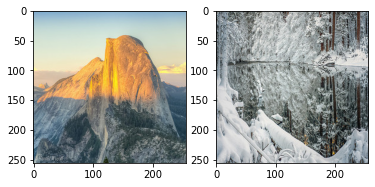

In [10]:
# display random sample images from summer and winter
plt.figure(figsize=(6, 3))
for imgs_A, imgs_B in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow((imgs_A[0]+1)/2)
    plt.subplot(1,2,2)
    plt.imshow((imgs_B[0]+1)/2)

In [ ]:
OUTPUT_CHANNELS = 3

In [11]:
# creating downsampling layer
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               use_bias=False))

    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
# creating upsampling layer
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
# creating generator model
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    # downsampling stack
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (batchsize, 128, 128, 64)
        downsample(128, 4), # (batchsize, 64, 64, 128)
        downsample(256, 4), # (batchsize, 32, 32, 256)
        downsample(512, 4), # (batchsize, 16, 16, 512)
        downsample(512, 4), # (batchsize, 8, 8, 512)
        downsample(512, 4), # (batchsize, 4, 4, 512)
        downsample(512, 4), # (batchsize, 2, 2, 512)
        downsample(512, 4), # (batchsize, 1, 1, 512)
    ]
    # upsampling stack
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (batchsize, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (batchsize, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (batchsize, 8, 8, 1024)
        upsample(512, 4), # (batchsize, 16, 16, 1024)
        upsample(256, 4), # (batchsize, 32, 32, 512)
        upsample(128, 4), # (batchsize, 64, 64, 256)
        upsample(64, 4), # (batchsize, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh') # (batchsize, 256, 256, 3)

    x = inputs

    # downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
generator_x = Generator()   # a——>b
generator_y = Generator()   # b——>a

In [13]:
# creating discriminator model
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    # downsampling
    down1 = downsample(64, 4, False)(inp) # (batchsize, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (batchsize, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (batchsize, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batchsize, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,use_bias=False)(zero_pad1)  # (batchsize, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batchsize, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
               1, 4, strides=1)(zero_pad2)  # (batchsize, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
discriminator_x = Discriminator()   # discriminator a
discriminator_y = Discriminator()   # discriminator b

In [16]:
# display' image function

def image_show():
    
    title=['Source domain','Target domain','Map']
    rendered_pictures = generator_x(example_input, training=False)
    rendered_picture = rendered_pictures[0]
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,3,1)
    plt.imshow((example_input[0].numpy()+1)/2)
    plt.title(title[0])
    plt.subplot(1,3,2)
    plt.imshow((example_target[0].numpy()+1)/2)       
    plt.title(title[1])
    plt.subplot(1,3,3)
    plt.imshow((rendered_picture.numpy()+1)/2)
    plt.title(title[2])
    plt.show()
    
    return rendered_pictures

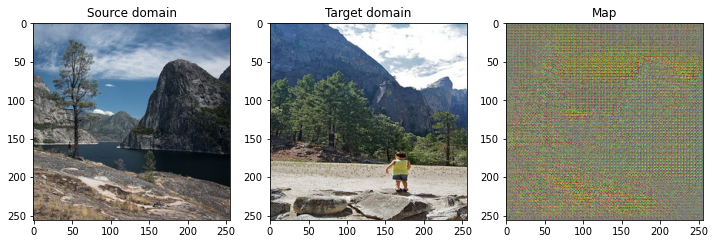

In [17]:
pred = image_show()

In [18]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 7

# creating loss functions

def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss


def generator_loss(disc_fake_output):
    gen_loss = loss_object(tf.ones_like(disc_fake_output), disc_fake_output)
    return gen_loss


def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

In [19]:
# setting optimizers

generator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [20]:
# function to train discriminator

def train_discriminator(image_a, image_b):
    with tf.GradientTape(persistent=True) as discriminator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        # pass through discriminator
        disc_real_a = discriminator_x(image_a, training=True)
        disc_real_b = discriminator_y(image_b, training=True)
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        # compute discriminator losses
        discriminator_x_loss = discriminator_loss(disc_real_a, disc_fake_a)
        discriminator_y_loss = discriminator_loss(disc_real_b, disc_fake_b)

    # compute gradients
    discriminator_x_gradients = discriminator_tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = discriminator_tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)

    # update weights
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [21]:
# function to train generator

def train_generator(image_a, image_b):
    with tf.GradientTape(persistent=True) as generator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        # pass through discriminator
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        # compute generator losses
        gen_x_loss = generator_loss(disc_fake_b)
        gen_y_loss = generator_loss(disc_fake_a)

        # compute cycle consistency loss
        total_cycle_loss = calc_cycle_loss(image_a, cycled_a) + calc_cycle_loss(image_b, cycled_b)

        # total generator losses
        total_gen_x_loss = gen_x_loss + total_cycle_loss
        total_gen_y_loss = gen_y_loss + total_cycle_loss

    # compute gradients
    generator_x_gradients = generator_tape.gradient(total_gen_x_loss, generator_x.trainable_variables)
    generator_y_gradients = generator_tape.gradient(total_gen_y_loss, generator_y.trainable_variables)

    # update weights
    generator_x_optimizer.apply_gradients(zip(generator_x_gradients, generator_x.trainable_variables))
    generator_y_optimizer.apply_gradients(zip(generator_y_gradients, generator_y.trainable_variables))

In [22]:
epochs = 30


Epoch 1/30 
Training: [--------->] 100 %  - 212 s

Epoch 2/30 
Training: [--------->] 100 %  - 184 s

Epoch 3/30 
Training: [--------->] 100 %  - 184 s

Epoch 4/30 
Training: [--------->] 100 %  - 184 s

Epoch 5/30 
Training: [--------->] 100 %  - 184 s


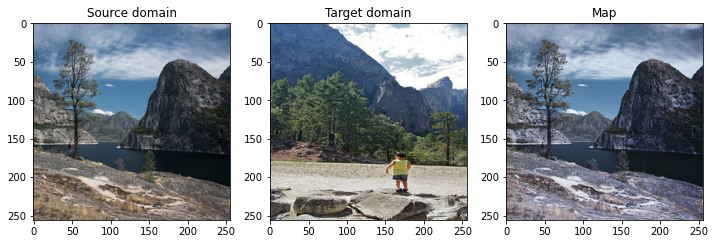


Epoch 6/30 
Training: [--------->] 100 %  - 184 s

Epoch 7/30 
Training: [--------->] 100 %  - 184 s

Epoch 8/30 
Training: [--------->] 100 %  - 184 s

Epoch 9/30 
Training: [--------->] 100 %  - 184 s

Epoch 10/30 
Training: [--------->] 100 %  - 184 s


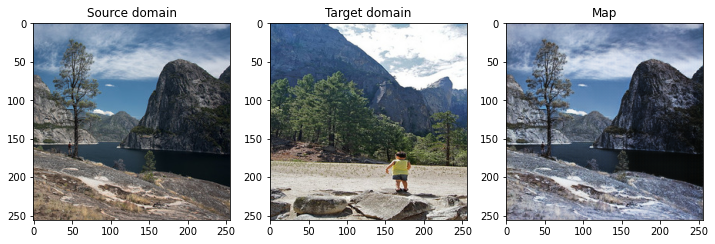


Epoch 11/30 
Training: [--------->] 100 %  - 184 s

Epoch 12/30 
Training: [--------->] 100 %  - 184 s

Epoch 13/30 
Training: [--------->] 100 %  - 185 s

Epoch 14/30 
Training: [--------->] 100 %  - 184 s

Epoch 15/30 
Training: [--------->] 100 %  - 185 s


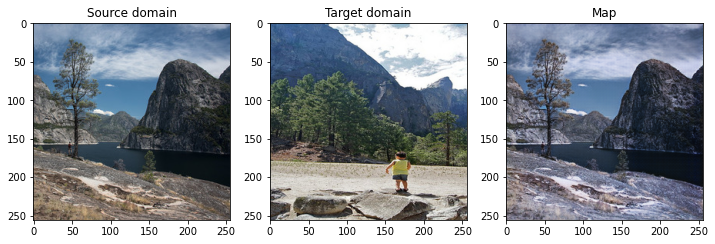


Epoch 16/30 
Training: [--------->] 100 %  - 185 s

Epoch 17/30 
Training: [--------->] 100 %  - 184 s

Epoch 18/30 
Training: [--------->] 100 %  - 184 s

Epoch 19/30 
Training: [--------->] 100 %  - 184 s

Epoch 20/30 
Training: [--------->] 100 %  - 184 s


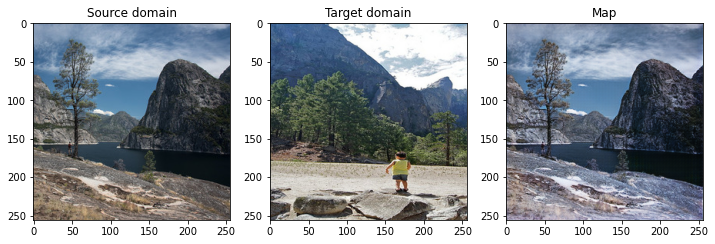


Epoch 21/30 
Training: [--------->] 100 %  - 184 s

Epoch 22/30 
Training: [--------->] 100 %  - 184 s

Epoch 23/30 
Training: [--------->] 100 %  - 184 s

Epoch 24/30 
Training: [--------->] 100 %  - 184 s

Epoch 25/30 
Training: [--------->] 100 %  - 184 s


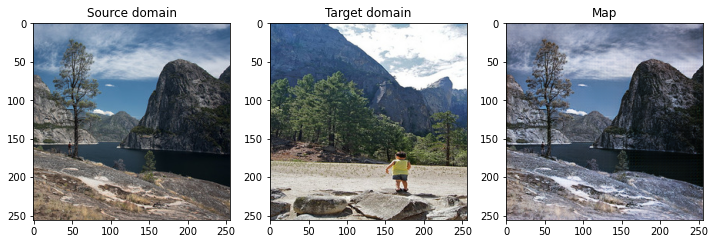


Epoch 26/30 
Training: [--------->] 100 %  - 184 s

Epoch 27/30 
Training: [--------->] 100 %  - 184 s

Epoch 28/30 
Training: [--------->] 100 %  - 184 s

Epoch 29/30 
Training: [--------->] 100 %  - 184 s

Epoch 30/30 
Training: [--------->] 100 %  - 184 s


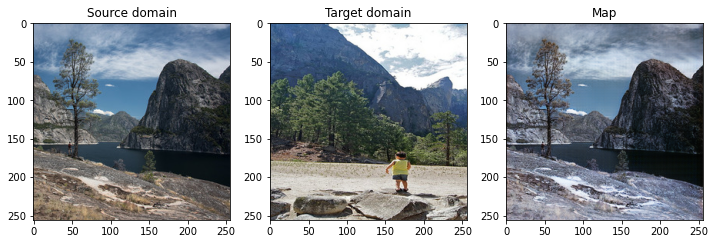

In [23]:
# training loop for cyclegans

for epoch in range(epochs):
    start = time.time()
    i = 0
    print ('\nEpoch {}/{} '.format(epoch+1, epochs))
    for img_a, img_b in train_dataset:
        
        train_discriminator(img_a, img_b)
        train_generator(img_a, img_b)
        
        percent = float(i+1) * 100 / len(train_dataset)
        arrow   = '-' * int(percent/100 * 10 - 1) + '>'
        spaces  = ' ' * (10 - len(arrow))
        print('\rTraining: [%s%s] %d %% '% (arrow, spaces, percent), end='', flush=True)
        i += 1
    print(" -", int(time.time()-start), "s", end="")
    print()
    
    if (epoch+1)%5==0:
        cache = image_show()